## K-Means Clustering

**Overview**<br>
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

## <font color = Green>1. Read and visualise the data </font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# read the dataset
ret_df = pd.read_csv('Online_retail.csv', sep=",", encoding="ISO-8859-1", header=0)
ret_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom


In [3]:
ret_df.shape

(541909, 8)

In [4]:
ret_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
ret_df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## <font color = Green>2. Data Cleaning </font>

In [6]:
# checking percentage of missing values
round(100*(ret_df.isnull().sum())/len(ret_df), 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [7]:
# dropping the records with missing values.
ret_df = ret_df.dropna()
ret_df.shape

(406829, 8)

So now the rest of the data looks pretty clean if encountered further we can handle on spot so stsrting with data preparation for clustering but, before starting that remember we are clustering for designing better strategies for various customer groups which is ussually done in marketing domain using **RFM analysis** .

## <font color = Green>3. Data Preparation </font>

**RFM analysis**  i.e 
- R (Recency): Number of days gap since last purchase.
- F (Frequency): Number of tracsactions.
- M (Monetary): Total amount of monetary value generated overall (revenue contributed).

Thus in such scenario the we need to find one of the missing attributes of RFM method from the dataset, so lets go ahead and add it and make the data useful.

 **a. Monetary**

In [8]:
# Adding a new column named "Amount"  
ret_df['Amount'] = ret_df['Quantity']*ret_df['UnitPrice']
ret_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00


In [9]:
# monetary 
grouped_amt_df = ret_df.groupby('CustomerID')['Amount'].sum()
grouped_amt_df = grouped_amt_df.reset_index()
grouped_amt_df.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


 **b. Frequency**
 Creating next RFM attribute.

In [10]:
grouped_freq_df = ret_df.groupby('CustomerID')['InvoiceNo'].count()
grouped_freq_df = grouped_freq_df.reset_index()
grouped_freq_df.columns = ['CustomerID', 'InvoiceNo']
grouped_freq_df.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [11]:
# merge the two dfs
grouped_df = pd.merge(grouped_amt_df, grouped_freq_df, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,Amount,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


#### c. Recency

In [12]:
# convert InvoiceDate type format from object to datetime
ret_df['InvoiceDate'] = pd.to_datetime(ret_df['InvoiceDate'], 
                                          format='%d-%m-%Y %H:%M')

In [13]:
ret_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   Amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [14]:
# compute the max date
max_date = max(ret_df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [15]:
# compute the diff
ret_df['diff'] = max_date - ret_df['InvoiceDate']
ret_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [16]:
# recency
last_purchase = ret_df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [17]:
# merging all three attributes of RFM.
RFM_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
RFM_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
RFM_df.head(3)

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00


In [18]:
# number of days only
RFM_df['recency'] = RFM_df['recency'].dt.days
RFM_df.head(3)

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74


## <font color = Green>5. [i] Outlier detection and treatment -Iteration 1 </font>

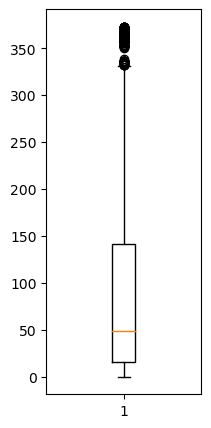

In [19]:
# 1. outlier treatment
plt.figure(figsize=(2,5))
plt.boxplot(RFM_df['recency'])
plt.show()

**Rescaling**

In [20]:
rfm_df = RFM_df[['amount', 'frequency', 'recency']]
rfm_df.head()

,amount,frequency,recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309


In [21]:
scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4372, 3)

In [22]:
rfm_df_scaled

array([[-0.23100099, -0.3917197 ,  2.32202285],
       [ 0.29343167,  0.38265697, -0.89373323],
       [-0.01231622, -0.26695902, -0.1691956 ],
       ...,
       [-0.20951263, -0.34439668, -0.83418219],
       [ 0.02390005,  2.85205812, -0.87388289],
       [-0.00744423, -0.0991774 , -0.48680114]])

In [23]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.231001,-0.391720,2.322023
1,0.293432,0.382657,-0.893733
2,-0.012316,-0.266959,-0.169196
3,-0.017146,-0.086271,-0.725005
4,-0.190312,-0.327188,2.163220


## <font color = Green>6. Modelling </font>

In [24]:
#fitting the kmeans over our rfm data scaled object and defining the No. of clusters and No. of iterations

kmeans = KMeans(n_clusters = 4, max_iter=50)

kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [25]:
kmeans.labels_

array([2, 0, 0, ..., 0, 0, 0])

##  Methods of finding the Optimal Number of Clusters

**a) Elbow-curve/ Sum Square Distances method** <br>
Most commonly used iterative type of unsupervised learning algorithm. Unlike supervised learning, 
The elbow method is a graphical representation of finding the optimal ‘K’ in a K-means clustering. It works by finding WCSS (Within-Cluster Sum of Square) i.e. the sum of the square distance between points in a cluster and the cluster centroid.

The elbow graph shows WCSS values(on the y-axis) corresponding to the different values of K(on the x-axis). When we see an elbow shape in the graph, we pick the K-value where the elbow gets created. We can call this point the Elbow point. Beyond the Elbow point, increasing the value of ‘K’ does not lead to a significant reduction in WCSS.

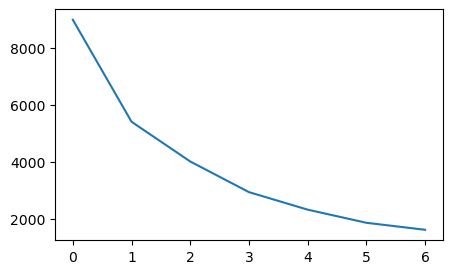

In [26]:
# elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd

plt.figure(figsize=(5, 3))
plt.plot(ssd)
plt.show()


# (0-1-2-3-4-5-6) represents (2,3,4,5,6,7,8) -no of clusters set in the series 

**b) Silhouette Analysis** 

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* **GOOD CLUSTER** :- A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* **BAD CLUSTER** :- A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [27]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.9293984525918874
For n_clusters=3, the silhouette score is 0.6003883114752382
For n_clusters=4, the silhouette score is 0.5981422039499412
For n_clusters=5, the silhouette score is 0.6160765093919002
For n_clusters=6, the silhouette score is 0.5856955818362631
For n_clusters=7, the silhouette score is 0.5238551448871509
For n_clusters=8, the silhouette score is 0.5057203874491681


So now post testing on both the possible methods Elbow & silhouette analysis we see the optimal cluster number comes to be 3 in both analysis but if we check the results of silhouette analysis model with 2 clusters seem to have the highest score but remember the goal of using kmeans method is to group the customers into various actionable/strategic segments to plan different strategies to ultimately promote the sales so ideally forming just 2 cluster does not makes sense after so much analysis.<br>
<br>Thus as of now 3 seems to be an ideal number here to have for clusters so we will move forward with it and if we feel any better solution can be formed than the existing model we can make the changes in the process.

In [28]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [29]:
kmeans.labels_

array([1, 0, 0, ..., 0, 0, 0])

In [30]:
# assign the label
RFM_df['cluster_id'] = kmeans.labels_
RFM_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


<AxesSubplot:xlabel='cluster_id', ylabel='amount'>

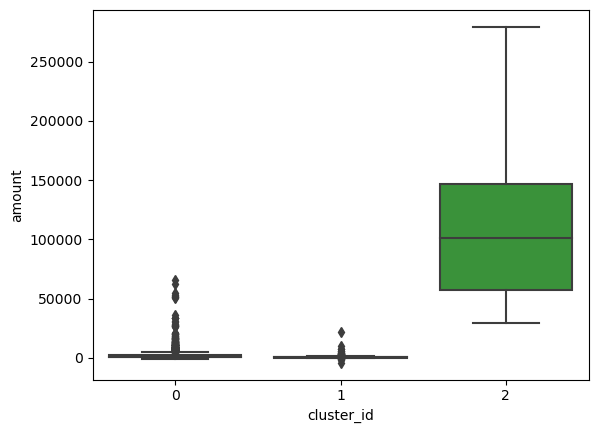

In [31]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=RFM_df)

## <font color = Green>5. [ii] Outlier detection and treatment - Iteration 2 </font>

**Rescaling**

In [32]:
# removing (statistical) outliers

# outlier treatment for amount
Q1 = RFM_df.amount.quantile(0.05)
Q3 = RFM_df.amount.quantile(0.95)
IQR = Q3 - Q1
RFM_df = RFM_df[(RFM_df.amount >= Q1 - 1.5*IQR) & (RFM_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = RFM_df.recency.quantile(0.05)
Q3 = RFM_df.recency.quantile(0.95)
IQR = Q3 - Q1
RFM_df = RFM_df[(RFM_df.recency >= Q1 - 1.5*IQR) & (RFM_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = RFM_df.frequency.quantile(0.05)
Q3 = RFM_df.frequency.quantile(0.95)
IQR = Q3 - Q1
RFM_df = RFM_df[(RFM_df.frequency >= Q1 - 1.5*IQR) & (RFM_df.frequency <= Q3 + 1.5*IQR)]

In [33]:
rfm_df = RFM_df[['amount', 'frequency', 'recency']]
rfm_df.head()

,amount,frequency,recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309


In [34]:
scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [35]:
rfm_df_scaled

array([[-0.72373821, -0.75288754,  2.30161144],
       [ 1.73161722,  1.04246665, -0.90646561],
       [ 0.30012791, -0.46363604, -0.18365813],
       ...,
       [-0.67769602, -0.70301659,  0.86589794],
       [-0.6231313 , -0.64317145, -0.84705678],
       [ 0.32293822, -0.07464263, -0.50050524]])

In [36]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


## <font color = Green>6. Modelling </font>

In [37]:
#fitting the kmeans over our rfm data scaled object and defining the No. of clusters and No. of iterations

kmeans = KMeans(n_clusters = 4, max_iter=50)

kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [38]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

##  Methods of finding the Optimal Number of Clusters

**a) Elbow-curve/ Sum Square Distances method** 

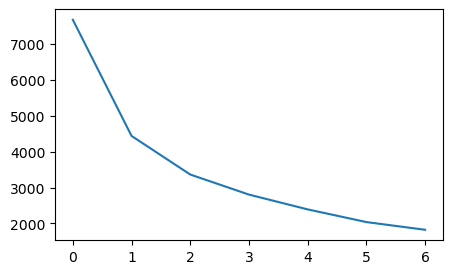

In [39]:
# elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd

plt.figure(figsize=(5, 3))
plt.plot(ssd)
plt.show()


# (0-1-2-3-4-5-6) represents (2,3,4,5,6,7,8) -no of clusters set in the series 

**b) Silhouette Analysis** 


* The value of the silhouette score range lies between -1 to 1. 

* **GOOD CLUSTER** :- A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* **BAD CLUSTER** :- A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [40]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4777820100216849
For n_clusters=5, the silhouette score is 0.46627005641897035
For n_clusters=6, the silhouette score is 0.41753051875511704
For n_clusters=7, the silhouette score is 0.41493333476205857
For n_clusters=8, the silhouette score is 0.4014674571019059


So now post testing on both the possible methods Elbow & silhouette analysis we see the optimal cluster number comes to be 3 in both analysis but if we check the results of silhouette analysis model with 2 clusters seem to have the highest score but remember the goal of using kmeans method is to group the customers into various actionable/strategic segments to plan different strategies to ultimately promote the sales so ideally forming just 2 cluster does not makes sense after so much analysis.<br>
<br>Thus as of now 3 seems to be an ideal number here to have for clusters so we will move forward with it and if we feel any better solution can be formed than the existing model we can make the changes in the process.

In [41]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [42]:
kmeans.labels_

array([0, 1, 2, ..., 0, 2, 2])

In [43]:
# assign the label
RFM_df['cluster_id'] = kmeans.labels_
RFM_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,0


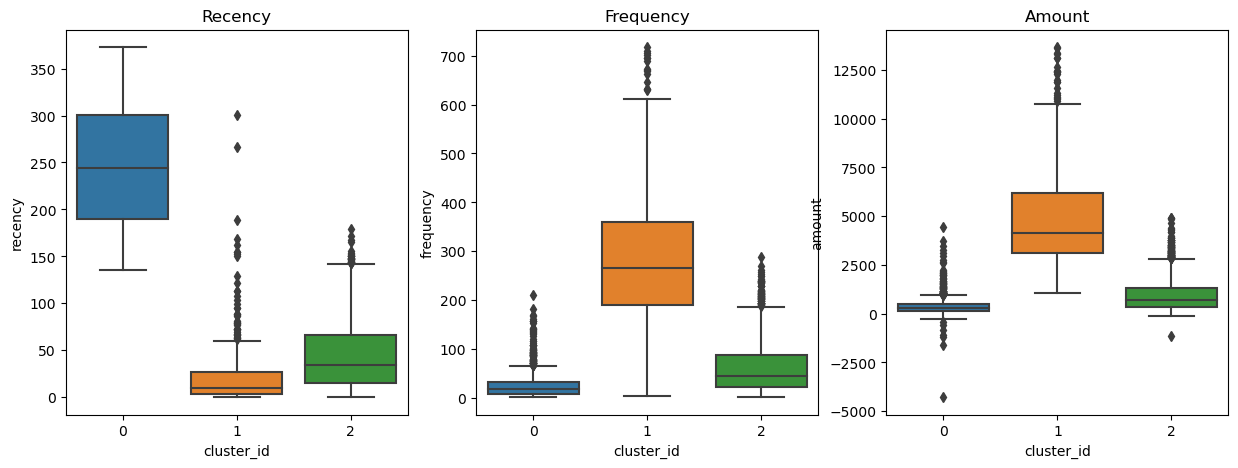

In [44]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))

# Generate a boxplot for Recency
sns.boxplot(x='cluster_id', y='recency', data=RFM_df, ax=axs[0])
axs[0].set_title("Recency")

# Generate a boxplot for Frequency
sns.boxplot(x='cluster_id', y='frequency', data=RFM_df, ax=axs[1])
axs[1].set_title("Frequency")

# Generate a boxplot for Monetary
sns.boxplot(x='cluster_id', y='amount', data=RFM_df, ax=axs[2])
axs[2].set_title("Amount")

# Display the plot
plt.show()

## Insights

Using 3 clusters formation we can draw the following insights for an RFM framework in K mean clustering algorithm:<br><br>
. **Recency** - Cluster 0 is the group of customers with very good turnaround time between 2  orders with gap being in range 190 to 300, followed by cluster 2 and 1 respectively.
<br><br>
. **Frequency** - After removing extreme outliers from datasets we can see great change in frequency aspect which tells about how frequent transactions are wherein the cluster-1 seem to have great deal of importance then cluster-2 and cluster-0.
<br><br>
. **Amount** - Most important variable in RFM amount/monetary here we see a trend similar to frequency.with higher number of customers in cluster 1 nd 2, 0 respectively.
<br>

<br>
Hence having 3 clusters with the following set of datapoints, removal of following outliers will lead to ideal grouping /segmentation to develop strategic solutions to promote sales identifying the nature of usersand cater to their needs.